<a href="https://colab.research.google.com/github/pinkdolphin11/ESAA/blob/main/5_16_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**06. XGBoost(eXtra Gradient Boost)**

[XGBoost 개요]

트리 기반 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나. 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능 나타냄

GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결한 GBM 기반 알고리즘. 병렬 CPU 환경에서 병렬 학습이 가능해 GBM보다 빠름

XGBoost의 장점

* Tree pruning(나무 가지치기) : 더 이상 긍정 이득이 없는 분할을 가지치기해서 분할 수를 더 줄임

* 자체 내장된 교차 검증 : 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수를 가짐. 평가 값이 최적화되면 반복을 중간에 멈추는 조기 중단 기능

* 결손값 자체 처리

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

[파이썬 래퍼 XGBoost 하이퍼 파라미터]

GBM과 유사한 하이퍼 파라미터+조기 중간(early stopping), 과적합 규제

* 일반 파라미터 : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터. 디폴트 값을 바꾸는 경우 거의 없음

  * booster : gbtree(tree based model, default) 또는 gblinear(linear model) 선택

  * silent : default 0, 출력 메시지를 나타내고 싶지 않을 경우 1

  * nthread : CPU의 실행 스레드 개수 조정(default : 모두 사용)

* 부스터 파라미터 : 트리 최적화, 부스팅, regularization 등 관련. 대부분은 여기에 속함

  * eta : GBM의 학습률(learning rate)과 같음. 부스팅 스탭을 반복적으로 수행할 때 업데이트되는 학습률 값(0 ~ 1). default=0.3, 사이킷런 래퍼 클래스 이용할 경우 learning_rate로 대체(default=0.1). 0.01 ~ 0.2 사이 값 선호

  * num_boost_rounds : GBM의 n_estimators

  * min_child_weight : 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 weight 총합. 값이 클수록 분할 자제(default=1). 과적합 조절

  * gamma : 트리의 리프 노드를 추가적으로 나눌지 결정할 최소 손실 감소 값. 해당 값보다 큰 손실이 감소된 경우 리프 노드 분리(default=0). 값 클수록 과적합 감소. alias : min_split_loss

  * max_depth : 트리 기반 알고리즘의 max_depth와 같음. 0을 지정하면 깊이 제한 없음. 높을수록 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성 높아짐. 3~10 사이 값 선호(default=6)

  * sub_sample : GBM의 subsample. 트리가 커져서 과적합되는 것을 제어하기 위해 데이터 샘플링 비율 지정. 0.5 ~ 1 사이 값 선호(default=1, 0 ~ 1 가능)

  * colsample_bytree : GBM의 max_features와 유사. 트리 생성에 필요한 피처(칼럼)를 임의로 샘플링. 피처가 많은 경우 과적합 조정에 적요얘(default=1)

  * lambda : L2 Regularization 적용 값. 피처 개수가 많을 경우 적용 검토, 값 클수록 과적합 감소(default=1, alias : reg_lambda)

  * alpha : L1 Regularization 적용 값.  피처 개수가 많을 경우 적용 검토, 값 클수록 과적합 감소(default=0, alias : reg_alpha)

  * scale_pos_weight : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터(default=1)

* 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등 설정

  * objective : 최솟값을 가져야 할 손실 함수 정의

  * binary:logistic : 이진 분류일 때 적용

  * multi:softmax : 다중 분류일 때 적용. 이게 손실함수인 경우 레이블 클래스의 개수인 num_class 파라미터 지정해야 함

  * multi:softprob : multi:softmax와 유사하나 개별 레이블 클래스의 해당되는 예측 확률 반환

  * eval_metric : 검증에 사용되는 함수 정의. 기본값은 회귀 rmse, 분류 error


과적합 문제가 심각할 경우 다음을 적용

* eta 낮추기(0.01 ~ 0.1). 이때 num_round(or n_estimators)는 높여야 함

* max_depth 낮추기

* min_child_weight 높이기

* gamma 높이기

* subsample, colsample_bytree 조정

XGBoost의 수행 속도를 향상시키기 위한 조기 중단 기능이 있다. 기본 GBM은 n_estimators(or num_boost_rounds)에 지정된 횟수만큼 반복적으로 학습 오류를 감소시키며 학습을 진행하면서 중간에 반복을 멈출 수 없고 지정된 횟수를 모두 완료해야 한다. XGBoost는 지정한 부스팅 반복 횟수에 도달하지 않아도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행 시간 개선 가능

In [ ]:
import xgboost
print(xgboost.__version__)

0.90


[파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측]

위스콘신 유방암 데이터 세트 : 종양의 크기, 모양 등 다양한 속성값을 기반으로 악성 종양(malignant)인지 양성 종양(benign)인지 분류한 데이터 세트

종양의 다양한 피처에 따라 종양이 악성인지 양성인지 XGBoost를 이용해 예측하자.

In [ ]:
import xgboost as xgb
from xgboost import plot_importance #plot_importance : 피처 중요도 시각화 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
#레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
#전체 데이터를 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


파이썬 래퍼 XGBoost는 사이킷런과 다르게 학습용과 테스트용 데이터 세트를 위해 별도의 객체 DMatrix를 생성한다. DMatrix는 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost 전용 데이터 세트이다. 주요 입력 파라미터는 data와 label이다. data는 피처 데이터 세트이며, label은 분류의 경우 레이블 데이터 세트, 회귀의 경우 숫자형 종속값 데이터 세트이다. 넘파이 외에 libsvm txt 포맷 파일, xgboost 이진 버퍼 파일을 파라미터로 입력받아 변환할 수 있다. 판다스의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환한 뒤 이를 이용해 DMatrix 변환을 적용한다.

In [ ]:
#넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

하이퍼 파라미터 설정

* max_depthO(트리 최대 깊이)=3

* 학습률 eta=0.1(XGBClassifier는 learning_rate)

* 예제 데이터가 0 또는 1인 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic)

* 오류 함수의 평가 성능 지표 : logloss

* num_rounds(부스팅 반복 횟수)=400

In [ ]:
#XGBoost 하이퍼 파라미터 설정(딕셔너리 형태로 입력)
params={'max_depth':3,'eta':0.1,'objective':'binary:logistic','eval_metric':'logloss','early_stoppings':100}
num_rounds=400

XGBoost 모델 학습

파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달한다.(사이킷런은 Estimator의 생성자를 하이퍼 파라미터로 전달). 조기 중단은 train() 함수에 early_stopping_rounds 파라미터를 입력하여 설정한다. 이때 반드시 eval_set와 eval_metric을 함께 설정해야 한다. XGBoost는 반복마다 eval_set로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류 측정

* eval_set : 성능 평가를 수행할 평가용 데이터 세트 설정

* eval_metric : 평가 세트에 적용할 성능 평가 방법 설정. 분류일 경우 error(분류 오류)나 logloss 적용

evals 파라미터에 학습 데이터 세트와 eval 데이터 세트를 명기해주면 평가를 eval 데이터 세트에 수행하면서 조기 중단을 적용한다. 그 다음 train() 함수를 호출하면 학습을 수행한다. 이때 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표 결과가 출력된다. train()은 학습이 완료된 모델 객체를 반환한다.

In [ ]:
#train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist=[(dtrain,'train'),(dtest,'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train() 함수에 전달
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,\
                    early_stopping_rounds=100,evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

train_error와 eval_logloss가 지속적으로 감소함을 확인할 수 있다.

학습 완료된 모델로 테스트 데이터 세트에 예측 수행

train()을 호출해 학습 완료된 모델 객체 반환, 예측을 위해 predict() 메서드 이용. 사이킷런의 predcit()는 예측 결과 클래스 값(0,1)을 반환하는 것과 달리 여기서는 예측 결과를 추정할 수 있는 확률 값 반환. 여기서는 암이 악성인지 양성인지 판단하는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 반환하는 로직을 추가하자.

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test,preds,pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


xgboost 패키지 내장 시각화 기능

plot_importance() : 피처의 중요도를 막대그래프 형식으로 나타냄. 기본 평가 지표는 f1 score. 호출 시 앞에서 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체를 파라미터로 입력

사이킷런은 Estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드를 작성해야 하지만 xgboost는 plot_importance()로 바로 시각화 가능

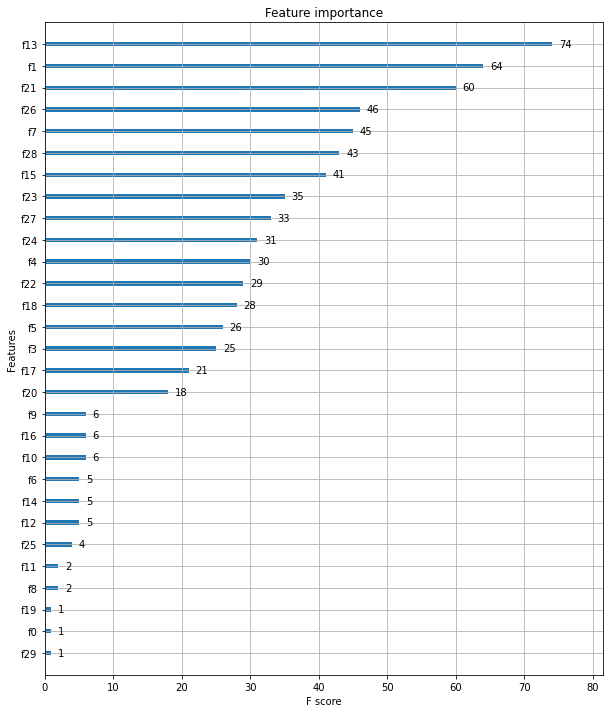

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 cv()로 제공. 반환값은 DataFrame 형태

* params (dict) : 부스터 파라미터

* dtrain (DMatrix) : 학습 데이정

* num_boost_round (int) : 부스팅 반복 횟수

* nfold (int) : CV 폴드 개수

* stratified (bool) : CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부

* metrics (string or list of strings) : CV 수행 시 모니터링할 성능 평가 지표

* early_stopping_rounds (int) : 조기 중단 활성화. 반복 횟수 지정

In [ ]:
xgboost.cv(params,dtrain,num_boost_round=10,nfold=3,stratified=False,folds=None,metrics=(),obj=None,feval=None,maximize=False,early_stopping_rounds=None,fpreproc=None,as_pandas=True,verbose_eval=None,show_stdv=True,seed=0,callbacks=None,shuffle=True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.610037,0.000064,0.617447,0.004961
1,0.541817,0.000202,0.555140,0.008989
2,0.483717,0.000955,0.503529,0.012238
3,0.434676,0.001311,0.459869,0.015795
4,0.392310,0.001686,0.423058,0.016788
5,0.355129,0.001390,0.391187,0.019785
6,0.322530,0.001908,0.361119,0.019378
7,0.294159,0.001618,0.337140,0.021086
8,0.269083,0.002068,0.314903,0.019972
9,0.246208,0.001940,0.295012,0.019237


[사이킷런 래퍼 XGBoost의 개요 및 적용]

분류를 위한 래퍼 클래스 XGBClassifier, 회귀를 위한 래퍼 클래스 XGBRegressor가 있다.

XGBClassifier는 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성을 유지하기 위해 기존 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터 몇 개를 다음과 같이 변경했다.

* eta - learning_rate

* sub_sample - subsample

* lambda - reg_lambda

* alpha - reg_alpha

또한 xgboost의 n_estimators와 num_boost_round 하이퍼 파라미터는 서로 동일하다. 사이킷런 래퍼 XGBoost 클래스에서는 n_estimators를 적용한다.

In [ ]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


파이썬 래퍼 XGBoost와 동일한 평가 결과가 나온다.

조기 중단을 수행하려면 관련 파라미터를 fit()에 입력한다. 평가 지표가 향상될 수 있는 반복 횟수를 정의하는 early_stopping_rounds, 조기 중단을 위한 평가 지표 eval_metric, 성능 평가를 수행할 데이터 세트 eval_set 파라미터가 있다. 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 한다.

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

n_estimators를 400으로 설정했지만 311번만 반복하고 학습을 완료했다. 211번 반복 시 logloss가 0.085593이고 311번 반복 시 0.085948인데, 211번에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문이다.

In [ ]:
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9954


조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 크다.

In [ ]:
#early_stopping_rounds=10으로 설정하고 재학습
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='logloss',eval_set=evals,verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws10_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


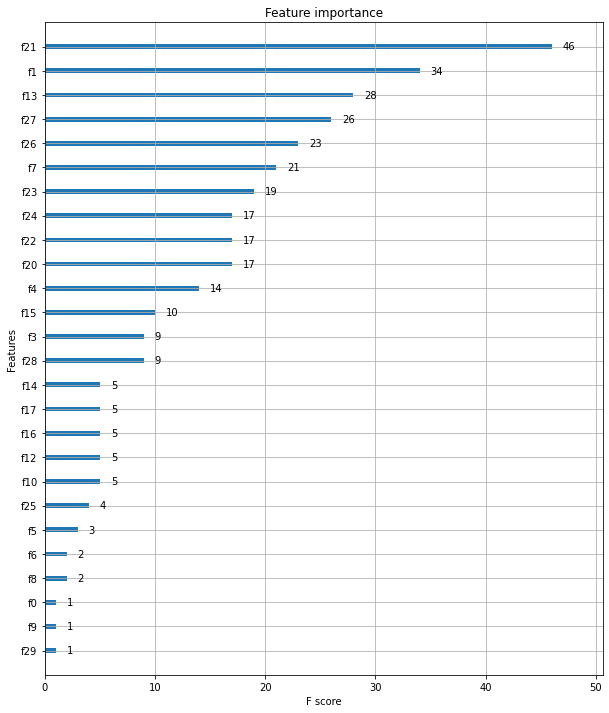

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper,ax=ax)

**07. LightGBM**

LightGBM은 XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광받고 있다. LightGBM은 XGBoost보다 학습에 걸리는 시간이 훨씬 적다. 단점은 10000건 이하의 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다는 것이다.

일반 GBM 계열의 트리 분할 방법(균형 트리 분할, Level Wise)과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용한다. 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성되는 것이다.

[LightGBM 하이퍼 파라미터]

XGBoost와 많은 부분이 유사하다.

* num_iterations(default=100) : 반복 수행하려는 트리 개수 지정. 크게 지정할수록 예측 성능이 높아지나 너무 크면 과적합으로 성능 저하. 사이킷런 GBM, XGBoost의 n_estimators와 같은 파라미터이므로 LightGBM의 사이킷런 호환 클래스에서는 n_estimators로 이름 변경

* learning_rate(default=0.1) : 0 ~ 1 사이 값 지정. 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값. 일반적으로 n_estimators를 크게 하고 learning_rate를 작게 해서 예측 성능을 향상. 과적합도 고려해야 함.

* max_depth(default=1) : 트리 기반 알고리즘의 max_depth와 동일. 0보다 작게 하면 깊이에 제한이 없음. leaf wise 기반이므로 깊이가 상대적으로 더 깊음

* min_data_in_leaf(default=20) : 결정 트리의 min_samples_leaf와 동일. LightGBMClassifier에서는 min_child_samples로 이름 변경. 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수. 과적합 제어

* num_leaves(default=31) : 하나의 트리가 가질 수 있는 최대 리프 개수

* boosting(default=gbdt, 일반적인 그래디언트 부스팅 결정 트리, rf는 랜덤포레스트) : 부스팅의 트리를 생성하는 알고리즘 기술

* bagging_fraction(default=1) : 과적합을 제어하기 위해 데이터 샘플링 비율 지정. subsample 파라미터와 동일

* feature_fraction(default=1) : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율. 과적합 방지. GBM의 max_features와 유사, XGBClassifier의 colsample_byfree와 동일

* lambda_l2 : L2 regulation 제어. 피처 개수가 많을 경우 적용. 클수록 과적합 감소. reg_lambda와 동일

* lambda_l1 : L1 regulation 제어.reg_alpha와 동일

Learning Task 파라미터

* objective : 최솟값을 가져야 할 손실함수 정의. Xgboost의 objective와 동일. 회귀, 다중 클래스 분류, 이진 분류 3가지 애플리케이션 유형에 따라 손실함수 지정

[하이퍼 파라미터 튜닝 방안]

num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하며 모델의 복잡도를 줄임


[LightGBM 적용 - 위스콘신 유방암 예측]

In [1]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr=dataset.data
target=dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr,target,test_size=0.2,random_state=156)

lgbm_wrapper=LGBMClassifier(n_estimators=400)

evals=[(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
preds=lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [ ]:
get_clf_eval(y_test,preds,pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740, F1: 0.9615, AUC:0.9926


**10. 스태킹 앙상블**

스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅 및 부스팅과 비슷하지만, 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 점에서 다르다.

스태킹 : 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 머신러닝 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식(메타 모델)

개별적인 기반 모델과, 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델이 필요하다. 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이 핵심이다.

스태킹 적용에는 많은 개별 모델이 필요하며, 일반적으로 성능이 비슷한 모델을 결합해 좀 더 나은 성능 향상을 도출하기 위해 적용된다.

[기본 스태킹 모델]

In [2]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data,y_label,test_size=0.2, random_state=0)

In [5]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100,random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [6]:
#개별 모델들을 학습
knn_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=100)

In [7]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test,knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test,dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test,ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용하자. 반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose()를 이용해 행과 열 위치를 바꾼 ndarray로 변환한다.

In [ ]:
pred=np.array([knn_pred,rf_pred,dt_pred,ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred,y_test)
final=lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,final)))

최종 메타 모델의 예측 정확도: 0.9737


[CV 세트 기반 스태킹]

과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 데이터 세트 이용

Step 1. 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성.

Step 2. 1에서 개별 모델들이 생성한 학습용/테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용/테스트용 데이터 세트 생성. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤 최종적으로 생성된 데이터 세트를 예측하고 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터 생성 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds 값으로 KFold 생성
    kf=KFold(n_splits=n_folds,shuffle=True,random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred=np.zeros((X_train_n.shape[0],1))
    test_pred=np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:',folder_counter,'시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr,y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:,folder_counter]=model.predict(X_test_n)
  
    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred,axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [15]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [16]:
Stack_final_X_train=np.concatenate((knn_train,rf_train,dt_train,ada_train),axis=1)
Stack_final_X_test=np.concatenate((knn_test,rf_test,dt_test,ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape,'원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:',Stack_final_X_train.shape,'스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [18]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
